<a href="https://colab.research.google.com/github/Jarvis-X/Aerial-Robotics-Course-Projects/blob/main/CS498HW5SingleTraj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The part where we follow a trajectory is based on the vehicle we controlled in HW4, so let's go over HW4 first!

Three propellers generate torques and forces in the body frame to translate and rotate the multirotor system. We can obtain the *local* wrench $\mathbf{w} = [\mathbf{f}^\top, \boldsymbol\tau^\top]^\top$ by using the mapping $\mathbf{A}$ from the input vector $\mathbf{u}$: $\mathbf{w=Au}$. Then accounting the effects of gravity, the rotation of the drone in the reference frame, and the inertia, we can obatin the derivative of the states by applying 
\begin{equation}
\dot{\mathbf{X}} = \begin{bmatrix}
        \frac{1}{m}\mathbf{R}^\top & \mathbf{O}\\
        \mathbf{O} & \mathbf{I}^{-1}_S
    \end{bmatrix}(\mathbf{A}\mathbf{u}
    - 
    \begin{bmatrix}
        nmg\mathbf{\hat e}_3\\
        \mathbf{I}_S\boldsymbol\omega\times\boldsymbol\omega
    \end{bmatrix}).
\end{equation}

We can find the way to calculate the `A` matrix in the code...

In [23]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# initial states: [x0, y0, theta0, dx0, dy0, dtheta0]
x0 = [0, 0, 0, 0, 0.5, 0]
# inertia
I = 1.0
# mass
m = 1.5
# Do we want cvx?
en_cvx = False
# Do we want constains?
en_constrain = False
# simulation time
time_out = 60

# number of motors
n = 3
# position of the thrusters
p = np.array([[-1, 0], [0, 1.5], [1, 0]]).T
# tilting angles of the propellers
alpha = np.array([-45, 10, 30])*np.pi/180.0
# A-matrix of the quadrotor
Af = np.zeros([2, n]);
Atau = np.zeros([1, n]);
R = np.zeros([2, 2*n]);
for i in range(n):
    R[:, 2*i:2*i+2] = [[np.cos(alpha[i]), -np.sin(alpha[i])],
                       [np.sin(alpha[i]), np.cos(alpha[i])]]
    Af[:,i] = R[:, 2*i:2*i+2].dot(np.array([0, 1]))
    Atau[:,i] = np.cross(p[:,i], R[:, 2*i:2*i+2].dot(np.array([0, 1])))

A = np.concatenate([Af, Atau], axis=0)
assert np.linalg.matrix_rank(A) == 3
# gravity acceleration
g = 9.8
# time step
dt = 0.05
# max force of a propeller
fM = 20.0
# minimum force of a propeller
fm = 0
# # desired state
# des_state = np.array([5, 5, 30.0/180*np.pi, 0, 0, 0])

In [24]:
# step function for the motion of the drone
def step(state, f):
    x, y, theta, dx, dy, dtheta = state
    # calculate wrench
    w = np.array([[np.cos(theta), -np.sin(theta), 0], 
                 [np.sin(theta), np.cos(theta), 0], 
                  [0, 0, 1]]).dot(A.dot(f))
    fx, fy, tau = w
    dstate = np.array([dx, dy, dtheta, fx/m, fy/m-g, tau/I])
    new_state = state + dstate*dt
    # make sure the range of theta is in (-pi, pi]
    if new_state[2] <= -np.pi:
        new_state[2] += 2*np.pi
    elif new_state[2] > np.pi:
        new_state[2] -= 2*np.pi
    return new_state

Once we have the curernt states $\mathbf{X}, \dot{\mathbf{X}}$ and the desired state $\mathbf{X}^{des}, \dot{\mathbf{X}}^{des}$, based on linear feedback, we can calculate the desired wrench by using a PID.

I made a mistake when designing the system. We have 3 DoF and 3 actuators. Thus, this is a non-redundent fully-actuated system. Therefore, by using $\mathbf{u} = \mathbf{A}^{-1}\mathbf{w}^{des}$, we are obtaining the only answer. Therefore, the convex optimization does not give any extra benefit here.

In [25]:
Kp = 1.5
Kd = 2.5
Ktheta = 1.5
Komega = 1.8
def control(state, des_state, en_cvx, en_constrain):
    theta = state[2]
    err = des_state - state
    if err[2] <= -np.pi:
        err[2] += 2*np.pi
    elif err[2] > np.pi:
        err[2] -= 2*np.pi
    # linear feedback
    des_w = np.array([Kp*err[0]+Kd*err[3], 
                      Kp*err[1]+Kd*err[4]+m*g, 
                      Ktheta*err[2]+Komega*err[5]])
    R = np.array([[np.cos(theta), -np.sin(theta), 0],
                  [np.sin(theta), np.cos(theta), 0], 
                  [0, 0, 1]])
    if en_cvx:
        # cvx to constrain the forces
        # Construct the problem.
        u = cp.Variable(n)
        objective = cp.Minimize(cp.norm_inf(u))
        constraints = [R*A*u == des_w, fm <= u, fM >= u]
        prob = cp.Problem(objective, constraints)
        # The optimal objective value is returned by `prob.solve()`.
        result = prob.solve()
        if prob.status == cp.OPTIMAL:
            f = u.value
        else:
            # Maybe we have no valid solution
            f = np.linalg.inv(A).dot(des_w)
    else:
        f = np.linalg.inv(A).dot(R.T.dot(des_w))
    
    if en_constrain: 
        return clamp(f, fm, fM)
    else:
        return f


def clamp(vec, minimum, maximum):
    for i in range(len(vec)):
        if vec[i] < minimum:
            vec[i] = minimum
        elif vec[i] > maximum:
            vec[i] = maximum
    return vec

# Trajectory functions

Given the initial and final states (including the position, velocity, acceleration), and the time to finish the trajectory, calculate the coefficients of a quintic trajectory

### Procedure
* polynomial(p) = `a0 + a1 * t + a2 * t**2 + a3 * t**3 + a4 * t**4 + a5 * t**5`
* derivative(v) = `a1 + 2*a2 * t + 3*a3 * t**2 + 4*a4 * t**3 + 5*a5 * t**4`
* double derivative(a) = `2*a2 + 6*a3 * t + 12*a4 * t**2 + 20*a5 * t**3`
* Making t = 0, we will get a0, a1, a2 by making p=x1, v=v1, and a=acc1
* Making t = delta_t, then insert the calculated a0, a1, a2 into the equations, we will get a3, a4, a5 by solving 3 first-order equations of p=x2, v=v2, and a=acc2

In [26]:
def state_to_state_traj(x1, x2, v1, v2, acc1, acc2, delta_t):
    # generate the time-stamps with an equal step
    t = np.arange(0, delta_t, dt)
    a0 = x1
    a1 = v1
    a2 = acc1/2

    # The coefficients are generated with the Mathematica script:
    # https://drive.google.com/file/d/1AJ7zPijAW1jco-QZTF0dMUIYxVBLG8-F/view?usp=sharing
    a3 = -(3*acc1*delta_t**2 - acc2*delta_t**2 + 12*delta_t*v1 + 8*delta_t*v2 + 20*x1 - 20*x2) / (2*delta_t**3)
    a4 = -(-3*acc1*delta_t**2 + 2*acc2*delta_t**2 - 16*delta_t*v1 - 14*delta_t*v2 - 30*x1 + 30*x2) / (2*delta_t**4)
    a5 = -((acc1*delta_t**2 - acc2*delta_t**2 + 6*delta_t*v1 + 6*delta_t*v2 + 12*x1 - 12*x2)/(2*delta_t**5))

    polynomial = a0 + a1 * t + a2 * t**2 + a3 * t**3 + a4 * t**4 + a5 * t**5
    derivative = a1 + 2*a2 * t + 3*a3 * t**2 + 4*a4 * t**3 + 5*a5 * t**4
    accel = 2*a2 + 6*a3 * t + 12*a4 * t**2 + 20*a5 * t**3
    return polynomial, derivative, accel


def piecewise2D (X, Y, Vx, Vy, Accx, Accy, T, num_points):
    x, y, dx, dy, ddx, ddy, t = [], [], [], [], [], [], []

    for i in range(num_points-1):          
        xi, dxi, ddxi = state_to_state_traj(X[i], X[i+1], Vx[i], Vx[i+1], Accx[i], Accx[i+1], T[i+1] - T[i])
        yi, dyi, ddyi = state_to_state_traj(Y[i], Y[i+1], Vy[i], Vy[i+1], Accy[i], Accy[i+1], T[i+1] - T[i])
        t_starti = T[i]

        x += xi.tolist()
        y += yi.tolist()
        dx += dxi.tolist()
        dy += dyi.tolist()
        ddx += ddxi.tolist()
        ddy += ddyi.tolist()
        t += (np.arange(0, T[i+1] - T[i], 0.05) + t_starti).tolist()

    plt.plot(x, y)
    return x, y, dx, dy, ddx, ddy, t

## Plotting functions

In [27]:
# Plotting
def plot_points():
    plt.plot(X,Y, '--')
    plt.plot(X,Y, 'o')
    plt.quiver(X,Y, Vx, Vy, color='r')
    plt.quiver(X,Y, Accx, Accy, color='b')
    
# Speed
def plot_speed():
    speed = np.sqrt(np.array(dx)**2 + np.array(dy)**2)
    plt.plot(time_stamps, speed)

# Acceleration
def plot_accel():
    accel = np.sqrt(np.array(ddx)**2 + np.array(ddy)**2)
    plt.plot(time_stamps, accel)

## Example on min-snap trajectory generation

In [28]:
##### Requirements for the trajectory

# Waypoints
p1 = [0.,0]
p2 = [2,3]
p3 = [4,5]
p4 = [5,-1]
p5 = [1,-1]

# Velocities
v1 = [0,0.5]
v2 = [1,1]
v3 = [1,0]
v4 = [-1,1]
v5 = [0,-0.001]

# Accelerations
acc1 = [0.05,0]
acc2 = [0.1,-0.2]
acc3 = [-0.1,0.2]
acc4 = [-0.1, -0.05]
acc5 = [0.05,0]

# Time
t1 = 0
t2 = 12
t3 = 22
t4 = 32
t5 = 42

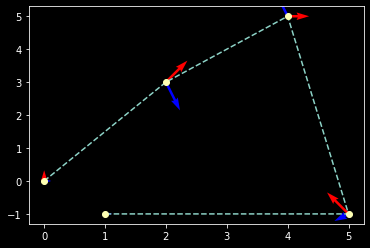

In [29]:
# Convert the initial conditions to a vector form
P = np.vstack((p1, p2, p3, p4, p5))
V = np.vstack((v1, v2, v3, v4, v5))
Acc = np.vstack((acc1, acc2, acc3, acc4, acc5))
T = [t1, t2, t3, t4, t5]

X, Y = P[:,0], P[:,1]
Vx, Vy = V[:,0], V[:,1]
Accx, Accy = Acc[:,0], Acc[:,1]
    
plot_points()

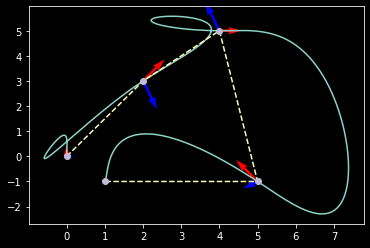

In [30]:
# Plot the trajectory that passes trhough the desired waypoints
x, y, dx, dy, ddx, ddy, time_stamps = piecewise2D(X,Y, Vx, Vy, Accx, Accy, T, len(P))
plot_points()

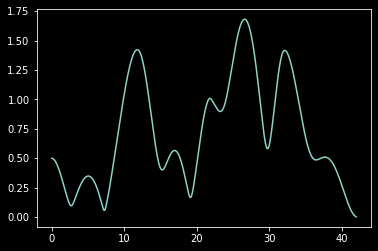

In [31]:
# Plot speed
plot_speed()

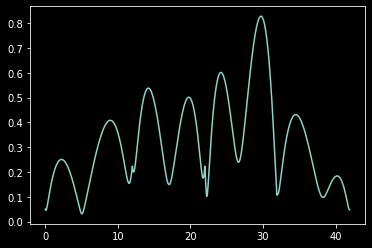

In [32]:
# plot acceleration
plot_accel()

# Trajectory Following simulation

In [33]:
def simulate(init_state, des_states, time_stamps, time_out=60):
    length = int(len(time_stamps))
    state_log = np.zeros((length, 6))
    f_log = np.zeros((length, n))
    state = init_state
    count = 0

    while count < length:
        state_log[count, :] = state
        des_state = des_states[:, count]
        f = control(state, des_state, en_cvx, en_constrain)
        f_log[count, :] = f
        state = step(state, f)
        count += 1
    return state_log, f_log

In [34]:
des_x, des_y, des_dx, des_dy = np.array(x), np.array(y), np.array(dx), np.array(dy)
des_theta = 0.2*np.ones(len(des_x))
des_dtheta = np.zeros(len(des_x))
des_states = np.vstack([des_x, des_y, des_theta, des_dx, des_dy, des_dtheta])

state_log, f_log = simulate(x0, des_states, time_stamps)
print(len(state_log))

840


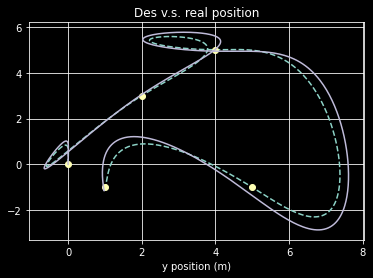

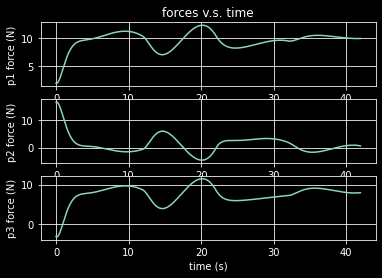

In [35]:
import matplotlib.pyplot as plt

fig1 = plt.figure()
ax11 = fig1.add_subplot(111)
ax11.grid()
ax11.plot(x, y, '--')
ax11.plot(X, Y, 'o')
ax11.set_xlabel('x position (m)')
ax11.set_xlabel('y position (m)')
ax11.set_title('Des v.s. real position')
ax11.plot(state_log[:, 0], state_log[:, 1])

fig2 = plt.figure()
ax21 = fig2.add_subplot(311)
ax21.grid()
ax21.set_ylabel('p1 force (N)')
ax21.set_title('forces v.s. time')
ax21.plot(time_stamps, f_log[:, 0])

ax22 = fig2.add_subplot(312)
ax22.grid()
ax22.set_ylabel('p2 force (N)')
ax22.set_xlabel('time (s)')
ax22.plot(time_stamps, f_log[:, 1])

ax23 = fig2.add_subplot(313)
ax23.grid()
ax23.set_ylabel('p3 force (N)')
ax23.set_xlabel('time (s)')
ax23.plot(time_stamps, f_log[:, 2])

In [36]:
!pip install JSAnimation

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML

fig, ax = plt.subplots()
plt.axis('equal')
sampling = int(2)

def animate(t):
    ax.clear()
    plt.xlim([-4, 8])
    plt.ylim([-4, 8])
    ax.grid()
    # Path
    plt.plot(state_log[:, 0], state_log[:, 1], 'b--')
    plt.plot(x, y, '--')
    plt.plot(X, Y, 'o')

    # current position and orientation
    ax.plot(state_log[sampling*t, 0], state_log[sampling*t, 1], 'ro')  # Center of mass
    ax.arrow(state_log[sampling*t, 0], state_log[sampling*t, 1], np.cos(state_log[sampling*t,2]), np.sin(state_log[sampling*t,2]), width=0.03, color=[0.5,0,0])
    # actuators
    # homogeneous vectors and rotations
    pos_p = np.zeros([2, n])
    rot_p = np.zeros([2, n])
    for i in range(n):
        # homogenenous transformation
        T = np.eye(3)
        T[0:2, 0:2] = np.array([[np.cos(state_log[sampling*t, 2]), -np.sin(state_log[sampling*t, 2])],
                                [np.sin(state_log[sampling*t, 2]), np.cos(state_log[sampling*t, 2])]])
        T[0:2, 2] = state_log[sampling*t, 0:2]
        pos_p[:, i] = T.dot(np.array([p[0, i], p[1, i], 1]))[0:2]
        rot_p[:, i] = T[0:2, 0:2].dot(R[:, 2*i:2*i+2].dot(f_log[sampling*t, i]*0.1*np.array([0, 1])))
        # print(rot_p)

    ax.plot(pos_p[0,:], pos_p[1, :], 'r.--')
    ax.plot([pos_p[0,-1], pos_p[0,0]], [pos_p[1, -1], pos_p[1, 0]], 'r.--')
    
    for i in range(n):
        ax.arrow(pos_p[0, i], pos_p[1, i], rot_p[0, i], rot_p[1, i], width=0.03, color=[0.5,0,0.5])
    
time = int(len(state_log)/sampling)
anim = animation.FuncAnimation(fig, animate, frames=time, interval=dt*1000*sampling)

HTML(anim.to_jshtml())